# **Installation**

In [1]:
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from scipy.stats import norm
import matplotlib.pyplot as plt
from plottable.cmap import normed_cmap
from mpl_toolkits.mplot3d import Axes3D
from plottable import ColumnDefinition, Table
from matplotlib.colors import LinearSegmentedColormap

# Ignoring warnings
warnings.filterwarnings("ignore")

# **Data Import**

In [2]:
df = pd.read_csv("strokes.csv")

# **Feature Engineering**

In [3]:
df['distance'] = df['distance']/36

df['distance_to_pin'] = df['distance_to_pin']/36

df['dist_to_hole_after_shot'] = df['dist_to_hole_after_shot']/36

df['dist_from_center'] = df['dist_from_center']/36

df['dist_from_edge'] = df['dist_from_edge']/36

In [4]:
selected_columns = ['player_id', 'last_name', 'round','hole','hole_score','par_value','yardage', 'shot', 'shot_type', 'num_of_strokes',
       'from_location_scorer', 'from_location_laser', 'to_location_scorer',
       'to_location_laser', 'distance', 'distance_to_pin', 'in_the_hole',
       'around_the_green', 'first_putt', 'dist_to_hole_after_shot', 'time',
       'lie', 'elevation', 'slope', 'x', 'y', 'z', 'dist_from_center',
       'dist_from_edge']  # Add the column names you want to select
df = df[selected_columns].copy()

shot_1 = df.loc[df['shot'] == 1]

driving_data = shot_1[shot_1['par_value'].isin([4,5])]

driving_data['Drive_length'] = driving_data['distance_to_pin'] - driving_data['dist_to_hole_after_shot']

righty_or_lefty = {    
    'Mickelson':'L',
    'Toms':'R',
    'Woodland':'R',
    'Simpson':'R',
    'Day':'R',
    'Snedeker':'R',
    'Watney':'R',
    'Reavie':'R',
    'Watson':'R',
    'Dufner':'R',
    'Byrd':'R',
    'Haas':'R',
    'Mahan':'R',
    'Yang':'R',
    'Scott':'R',
    'Choi':'R',
    'Donald':'R',
    'Van Pelt':'R',
    'Kuchar':'R',
    'Rose':'R',
    'Ogilvy':'R',
    'Howell III':'R',
    'Wilson':'R',
    'Jacobson':'R',
    'Senden':'R',
    'Singh':'R',
    'Johnson':'R',
    'Baddeley':'R',
    'Bradley':'R',
    'Stricker':'R'
}

# Add bio metrics

driving_data['Golfer_hand'] = driving_data['last_name'].map(righty_or_lefty)

driving_data['dist_from_center'] = driving_data['dist_from_center'].abs()

In [5]:
sg_drive_calc = driving_data.groupby(['round', 'hole']).agg({
    'Drive_length': 'mean',
    'dist_from_center': 'mean',
    'hole_score': 'mean'  # Add this line for 'hole_score'
}).reset_index()

sg_drive_calc.rename(columns={
    'Drive_length': 'avg_drv_lngth_per_round',
    'dist_from_center': 'avg_dist_from_center_per_round',
    'hole_score': 'avg_hole_score_per_round'  # Rename for clarity
}, inplace=True)

In [6]:
# Assuming sg_calc and condensed_df are your DataFrames
driving_data['Dg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_drv_lngth_per_round'].iloc[0] - row['Drive_length'],
    axis=1
)

driving_data['avg_drv_lngth_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_drv_lngth_per_round'].iloc[0],
    axis=1
)

# Display the resulting DataFrame
driving_data['Dg_per_hole_per_round_per_player'] = driving_data['Dg_per_hole_per_round_per_player'] * -1

# Assuming sg_calc and condensed_df are your DataFrames
driving_data['sg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_hole_score_per_round'].iloc[0] - row['hole_score'],
    axis=1
)

driving_data['avg_hole_score_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_hole_score_per_round'].iloc[0],
    axis=1
)

# Assuming sg_calc and condensed_df are your DataFrames
driving_data['cg_per_hole_per_round_per_player'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_dist_from_center_per_round'].iloc[0] - row['dist_from_center'],
    axis=1
)

driving_data['avg_dist_from_center_per_round'] = driving_data.apply(
    lambda row: sg_drive_calc.loc[(sg_drive_calc['round'] == row['round']) & (sg_drive_calc['hole'] == row['hole']), 'avg_dist_from_center_per_round'].iloc[0],
    axis=1
)

driving_data = driving_data.loc[driving_data['Dg_per_hole_per_round_per_player'] > -200]

# **Driving Distance Analysis**

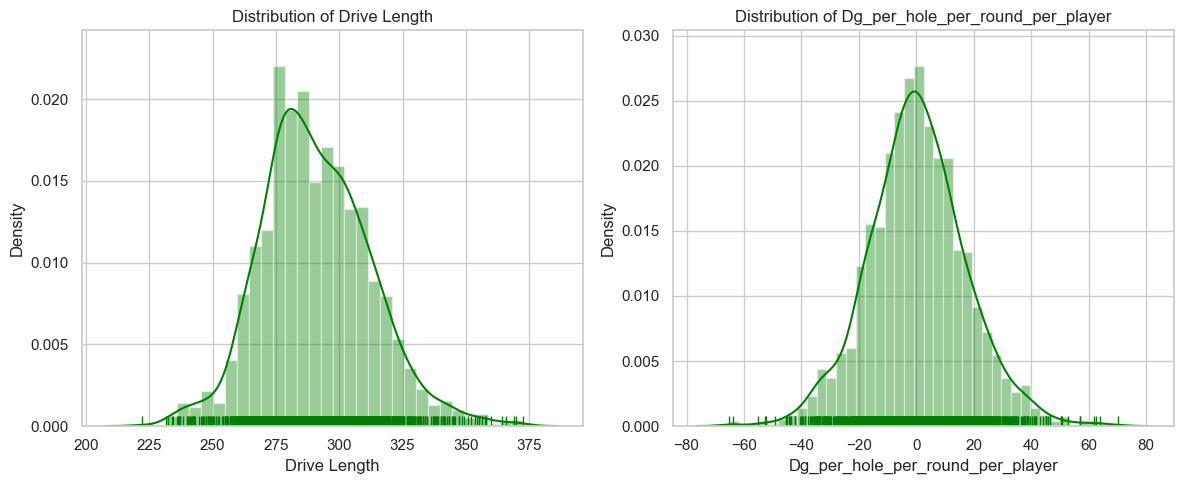

In [7]:
# Set a white grid background for a cleaner look
sns.set(style="whitegrid")

# Create a subplot with two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot 1: Distribution of Drive Length
sns.distplot(driving_data['distance'], kde=True, rug=True, ax=axes[0],color='green')
axes[0].set_xlabel('Drive Length')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Drive Length')

# Plot 2: Distribution of Dg_per_hole_per_round_per_player
sns.distplot(driving_data['Dg_per_hole_per_round_per_player'], kde=True, rug=True, ax=axes[1],color='green')
axes[1].set_xlabel('Dg_per_hole_per_round_per_player')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Dg_per_hole_per_round_per_player')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


# **SG vs DG**

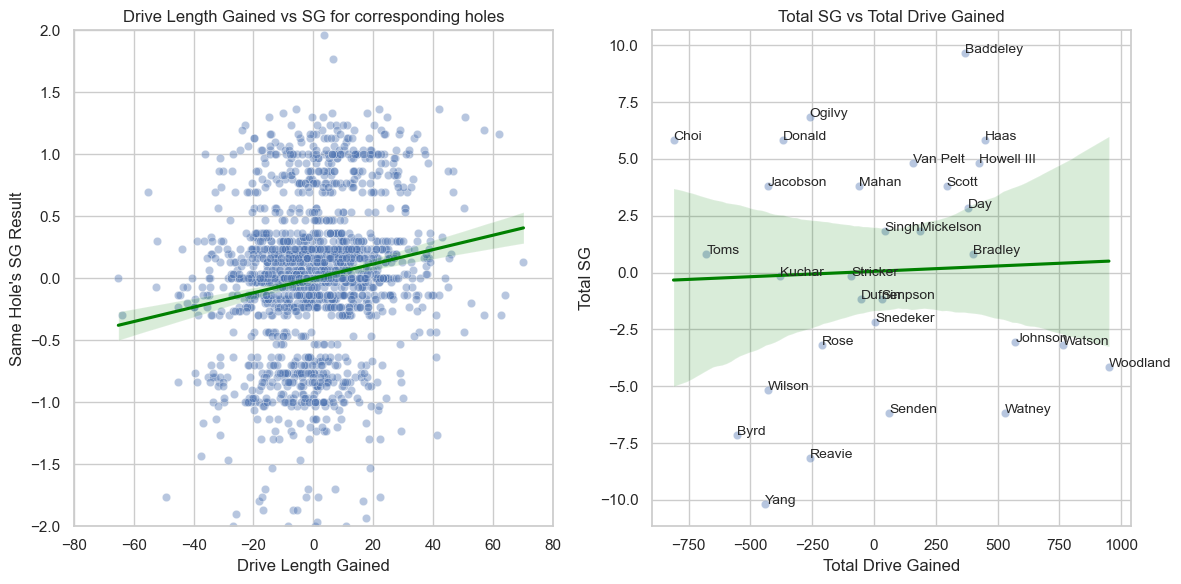

In [8]:
# Plot 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data=driving_data, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', alpha=0.4, palette='viridis')
sns.regplot(data=driving_data, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='green',order=1)

plt.title('Drive Length Gained vs SG for corresponding holes')
plt.xlabel('Drive Length Gained')
plt.ylabel("Same Hole's SG Result")
plt.xlim(-80, 80)
plt.ylim(-2, 2)

# Plot 2
plt.subplot(1, 2, 2)

result = driving_data.groupby('last_name').agg({
    'Dg_per_hole_per_round_per_player': 'sum',
    'sg_per_hole_per_round_per_player': 'sum'
}).reset_index().sort_values(by='Dg_per_hole_per_round_per_player', ascending=False)

sns.scatterplot(data=result, x=result.Dg_per_hole_per_round_per_player, y=result.sg_per_hole_per_round_per_player, alpha=0.4)
sns.regplot(data=result, x='Dg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='green',order=1)

plt.title('Total SG vs Total Drive Gained')
plt.xlabel('Total Drive Gained')
plt.ylabel('Total SG')

for index, row in result.iterrows():
    plt.text(row['Dg_per_hole_per_round_per_player'], row['sg_per_hole_per_round_per_player'], row['last_name'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [9]:
shot_1 = df.loc[df['shot'] == 1]
avg_round = shot_1.groupby(['player_id', 'round','hole']).agg({'distance': 'sum'}).reset_index()
dg_calc = avg_round.groupby(['hole','round'])['distance'].mean().reset_index()
dg_calc.rename(columns={'distance': 'avg_Drive_length_per_hole_per_round'}, inplace=True)

# Assuming dg_calc and df are your DataFrames
df['Dg_per_hole_per_round_per_player'] = df.apply(
    lambda row: dg_calc.loc[(dg_calc['round'] == row['round']) & (dg_calc['hole'] == row['hole']), 'avg_Drive_length_per_hole_per_round'].iloc[0] - row['distance'],
    axis=1
)

df['avg_Drive_length_per_hole_per_round'] = df.apply(
    lambda row: dg_calc.loc[(dg_calc['round'] == row['round']) & (dg_calc['hole'] == row['hole']), 'avg_Drive_length_per_hole_per_round'].iloc[0],
    axis=1
)

df['Dg_per_hole_per_round_per_player'] = df['Dg_per_hole_per_round_per_player'] * -1

In [10]:
df = df.sort_values(by=['player_id', 'round', 'hole'])

df = df[~df.duplicated(subset=['last_name', 'round', 'hole'], keep='first')]

# Calculate the rolling sum for each 'player_id'
df['rolling_sum_dg_per_hole_per_round_per_player'] = df.groupby('player_id')['Dg_per_hole_per_round_per_player'].rolling(window=72, min_periods=1).sum().reset_index(level=0, drop=True)

df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

# **Rolling DG**

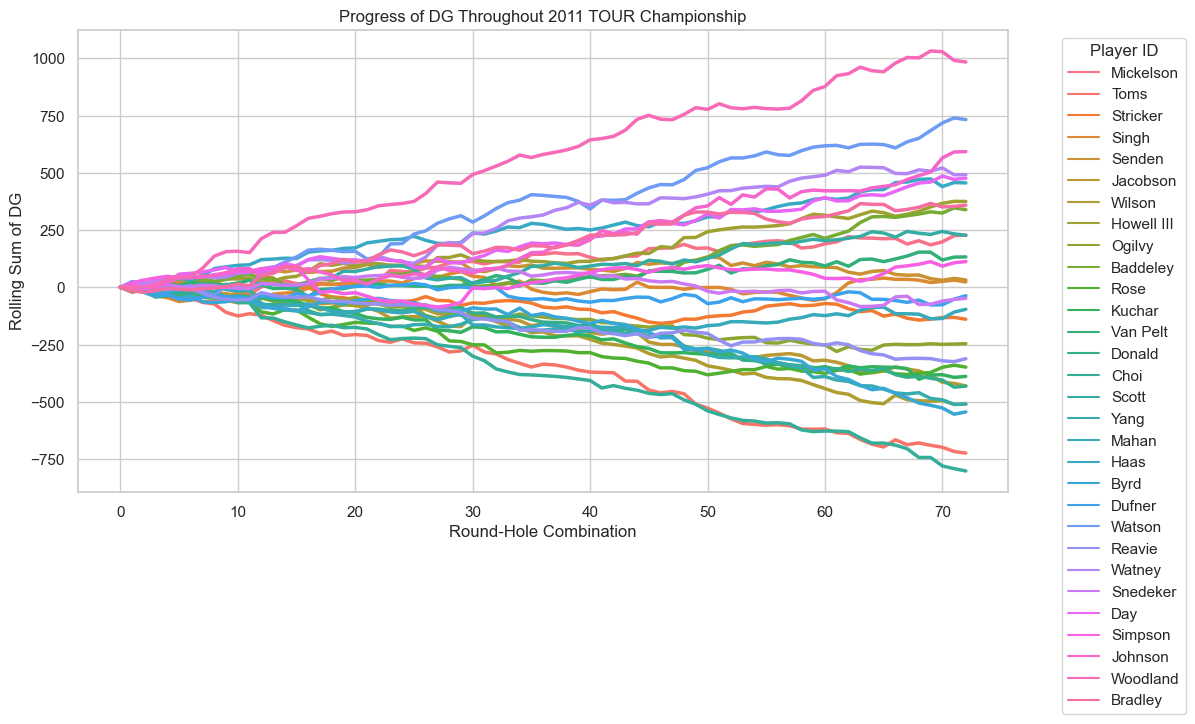

In [11]:
original_df = df[['last_name', 'round_hole_combination', 'Dg_per_hole_per_round_per_player', 'rolling_sum_dg_per_hole_per_round_per_player']]

# Create a new DataFrame with additional rows
extra_rows = pd.DataFrame(columns=original_df.columns)

# Iterate through unique player_ids and add rows with specified conditions
for player_id in original_df['last_name'].unique():
    extra_row = pd.DataFrame({'last_name': [player_id], 'round_hole_combination': [0], 'Dg_per_hole_per_round_per_player': [0], 'rolling_sum_dg_per_hole_per_round_per_player': [0]})
    extra_rows = pd.concat([extra_rows, extra_row], ignore_index=True)

# Concatenate the original DataFrame and the new rows
new_df = pd.concat([original_df, extra_rows], ignore_index=True)


palette = sns.color_palette("husl", n_colors=len(new_df['last_name'].unique()))

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=new_df, x='round_hole_combination', y='rolling_sum_dg_per_hole_per_round_per_player', hue='last_name', palette=palette, linewidth=2.5)

# Set labels and title
plt.xlabel('Round-Hole Combination')
plt.ylabel('Rolling Sum of DG')
plt.title('Progress of DG Throughout 2011 TOUR Championship')

# Customize the legend to show more players
plt.legend(title='Player ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [12]:
player_list = df['last_name'].unique().tolist()
list_of_lists_dg_per_hole_per_round_per_players = []
results_list = []

for player in range(0, len(player_list)):  # Assuming holes range from 1 to 18
    list_of_lists_dg_per_hole_per_round_per_players = df[
        (df['last_name'] == player_list[player])
    ]['Dg_per_hole_per_round_per_player'].values.tolist()
    
    params = stats.norm.fit(list_of_lists_dg_per_hole_per_round_per_players)
    
    result_dict = {
        'Player': player_list[player],
        'DG':sum(list_of_lists_dg_per_hole_per_round_per_players),
        'Mean': params[0],
        'Std': params[1]
    }

    results_list.append(result_dict)

        # print(f"Round {round_num}, player {player}:")
        # print("Fitted Mean:", params[0])
        # print("Fitted Standard Deviation:", params[1])

# Now results_list contains dictionaries for each combination of round and hole with mean and std.

df_results = pd.DataFrame(results_list)

df_results = df_results.sort_values(by='Mean',ascending=False)

df_results = df_results.reset_index(drop=True)

df_results['Mean'] = df_results['Mean'].round(2)
df_results['DG'] = df_results['DG'].round(2)
df_results['Std'] = df_results['Std'].round(2)

df_results_final = df_results

# **Driving Accuracy Analysis**

In [13]:
#df[['to_location_laser','to_location_scorer','dist_from_center', 'dist_from_edge']].drop_duplicates(subset=['to_location_laser','to_location_scorer'])

df['lie_location'] =    np.where(df['to_location_laser'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Rough', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Bunker', case=False), 'Bunker',
                        np.where(df['to_location_scorer'].str.contains('Green', case=False), 'Green',
                        np.where(df['to_location_laser'].str.contains('Fairway', case=False), 'Fairway',
                        np.where(df['to_location_scorer'].str.contains('Tree', case=False), 'Rough',
                        np.where(df['to_location_scorer'].str.contains('Water', case=False), 'Water', 'Unknown')))))))

#df[['to_location_laser','to_location_scorer','dist_from_center', 'dist_from_edge','lie_location']].drop_duplicates(subset=['to_location_laser','to_location_scorer'])

df['fairway_hit'] = np.where((df['lie_location'] == 'Green') | (df['lie_location'] == 'Fairway'), True, False)


# **Fairways Hit**

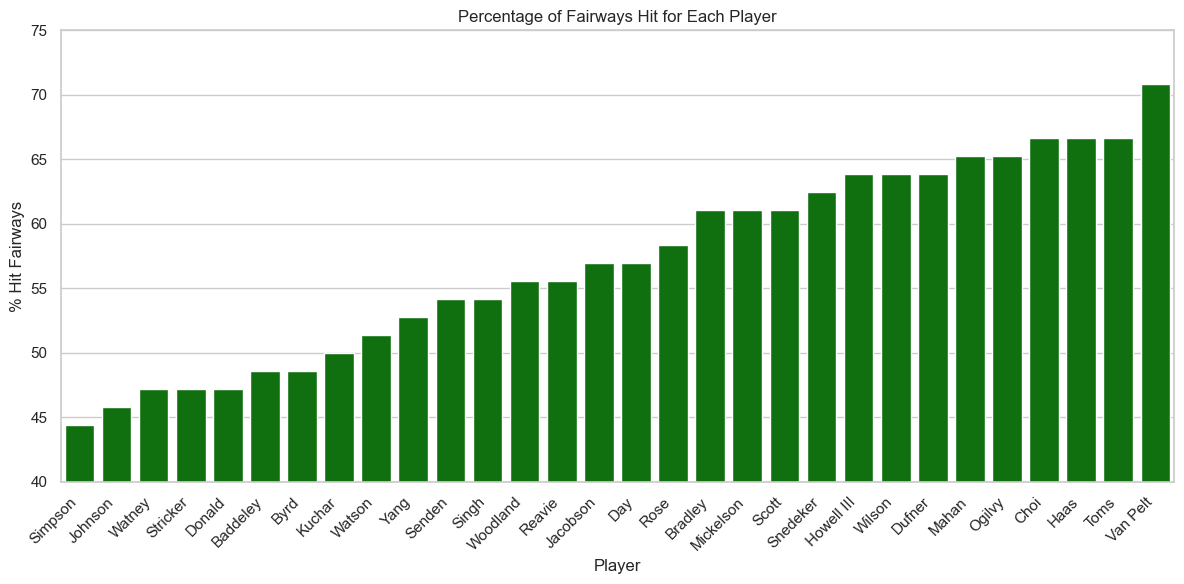

In [14]:
percentage_true = df.groupby('last_name')['fairway_hit'].mean() * 100
percentage_true = percentage_true.reset_index()
percentage_true = percentage_true.sort_values(by='fairway_hit',ascending=True)

plt.figure(figsize=(12, 6))
# Create a bar chart using Seaborn
sns.barplot(x='last_name', y='fairway_hit', data=percentage_true, color='green', dodge=True)
plt.title('Percentage of Fairways Hit for Each Player')
plt.xlabel('Player')
plt.ylabel('% Hit Fairways')
plt.ylim(40, 75)  # Set y-axis limit to ensure the correct scale

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Show the plot
plt.show()

#create a new bar chart later, stacked with more indepth bunker, water, rough options

#for this one eventually color by strokes gained

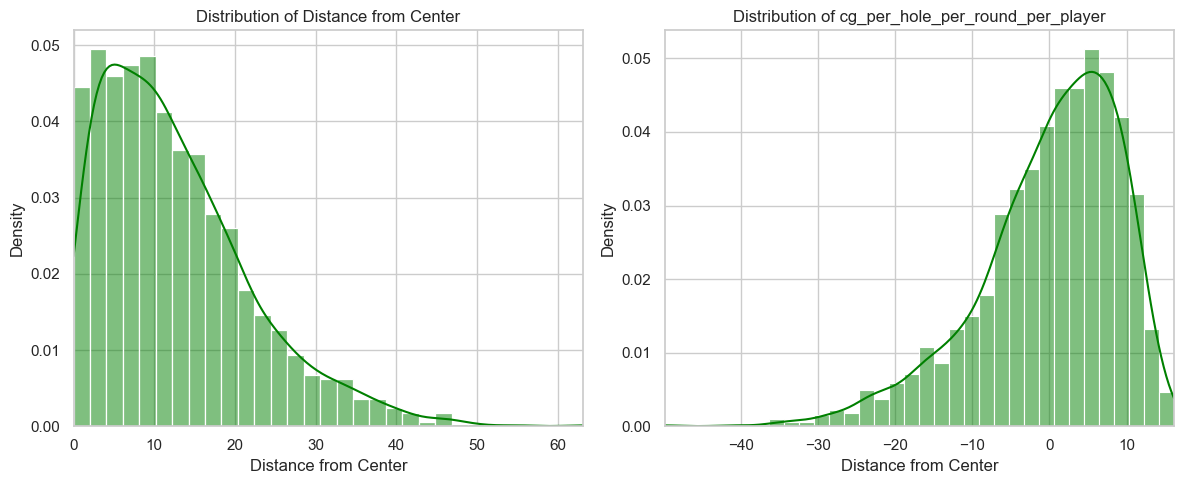

In [15]:
# Set a white grid background for a cleaner look
sns.set(style="whitegrid")

# Create a subplot with two columns
plt.figure(figsize=(12, 5))

# Plot 1: Distribution of Distance from Center
plt.subplot(1, 2, 1)
sns.histplot(driving_data['dist_from_center'], kde=True, stat='density', color='green')
plt.xlim(left=driving_data['dist_from_center'].min(), right=driving_data['dist_from_center'].max())
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.title('Distribution of Distance from Center')

# Plot 2: Distribution of cg_per_hole_per_round_per_player
plt.subplot(1, 2, 2)
sns.histplot(driving_data['cg_per_hole_per_round_per_player'], kde=True, stat='density', color='green')
plt.xlim(left=driving_data['cg_per_hole_per_round_per_player'].min(), right=driving_data['cg_per_hole_per_round_per_player'].max())
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.title('Distribution of cg_per_hole_per_round_per_player')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

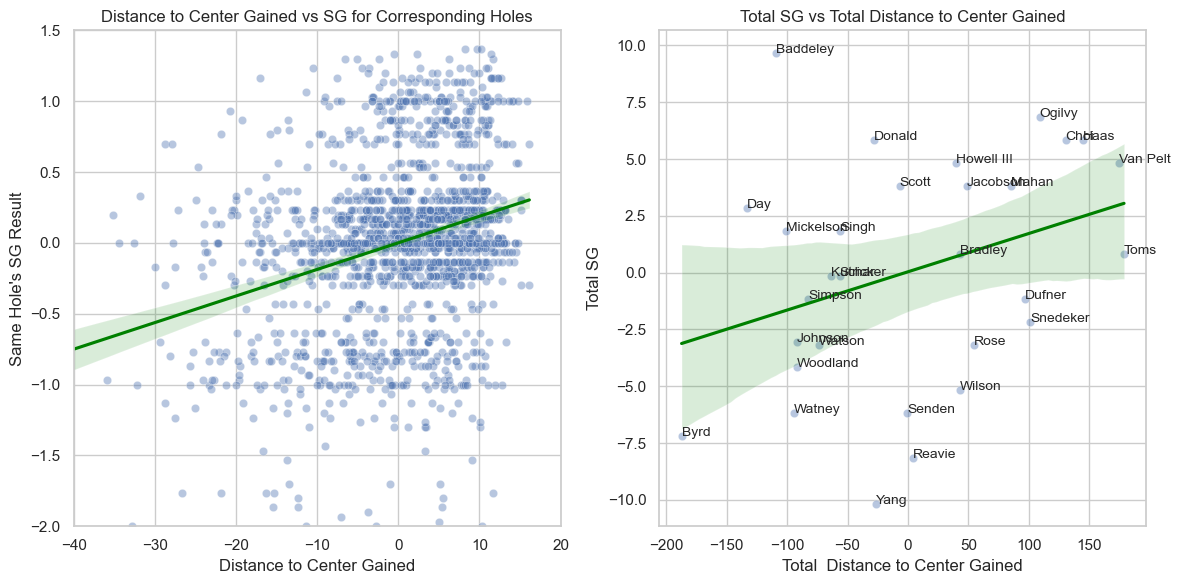

In [16]:
# Plot 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data=driving_data, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', alpha=0.4, palette='viridis')
sns.regplot(data=driving_data, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='green',order=1)
plt.title('Distance to Center Gained vs SG for Corresponding Holes')
plt.xlabel('Distance to Center Gained')
plt.ylabel("Same Hole's SG Result")
plt.xlim(-40, 20)
plt.ylim(-2,1.5)

# Plot 2
plt.subplot(1, 2, 2)

result = driving_data.groupby('last_name').agg({
    'cg_per_hole_per_round_per_player': 'sum',
    'sg_per_hole_per_round_per_player': 'sum'
}).reset_index().sort_values(by='cg_per_hole_per_round_per_player', ascending=False)

sns.scatterplot(data=result, x=result.cg_per_hole_per_round_per_player, y=result.sg_per_hole_per_round_per_player, alpha=0.4)
sns.regplot(data=result, x='cg_per_hole_per_round_per_player', y='sg_per_hole_per_round_per_player', scatter=False, color='green', order=1)

plt.title('Total SG vs Total Distance to Center Gained')
plt.xlabel('Total  Distance to Center Gained')
plt.ylabel('Total SG')

for index, row in result.iterrows():
    plt.text(row['cg_per_hole_per_round_per_player'], row['sg_per_hole_per_round_per_player'], row['last_name'], fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [17]:
shot_1 = df.loc[df['shot'] == 1]
avg_round = shot_1.groupby(['player_id', 'round','hole']).agg({'dist_from_center': 'sum'}).reset_index()
cg_calc = avg_round.groupby(['hole','round'])['dist_from_center'].mean().reset_index()
cg_calc.rename(columns={'dist_from_center': 'avg_dfc_per_hole_per_round'}, inplace=True)

# Assuming cg_calc and df are your DataFrames
df['cg_per_hole_per_round_per_player'] = df.apply(
    lambda row: cg_calc.loc[(cg_calc['round'] == row['round']) & (cg_calc['hole'] == row['hole']), 'avg_dfc_per_hole_per_round'].iloc[0] - row['dist_from_center'],
    axis=1
)

df['avg_dfc_per_hole_per_round'] = df.apply(
    lambda row: cg_calc.loc[(cg_calc['round'] == row['round']) & (cg_calc['hole'] == row['hole']), 'avg_dfc_per_hole_per_round'].iloc[0],
    axis=1
)

# df[['dist_from_center','avg_dfc_per_hole_per_round','cg_per_hole_per_round_per_player']]

In [18]:
df = df.sort_values(by=['player_id', 'round', 'hole'])

df = df[~df.duplicated(subset=['last_name', 'round', 'hole'], keep='first')]

# Calculate the rolling sum for each 'player_id'
df['rolling_sum_cg_per_hole_per_round_per_player'] = df.groupby('player_id')['cg_per_hole_per_round_per_player'].rolling(window=72, min_periods=1).sum().reset_index(level=0, drop=True)

df['round_hole_combination'] = (df['round'] - 1) * 18 + df['hole']

# **Rolling Accuracy Gained**

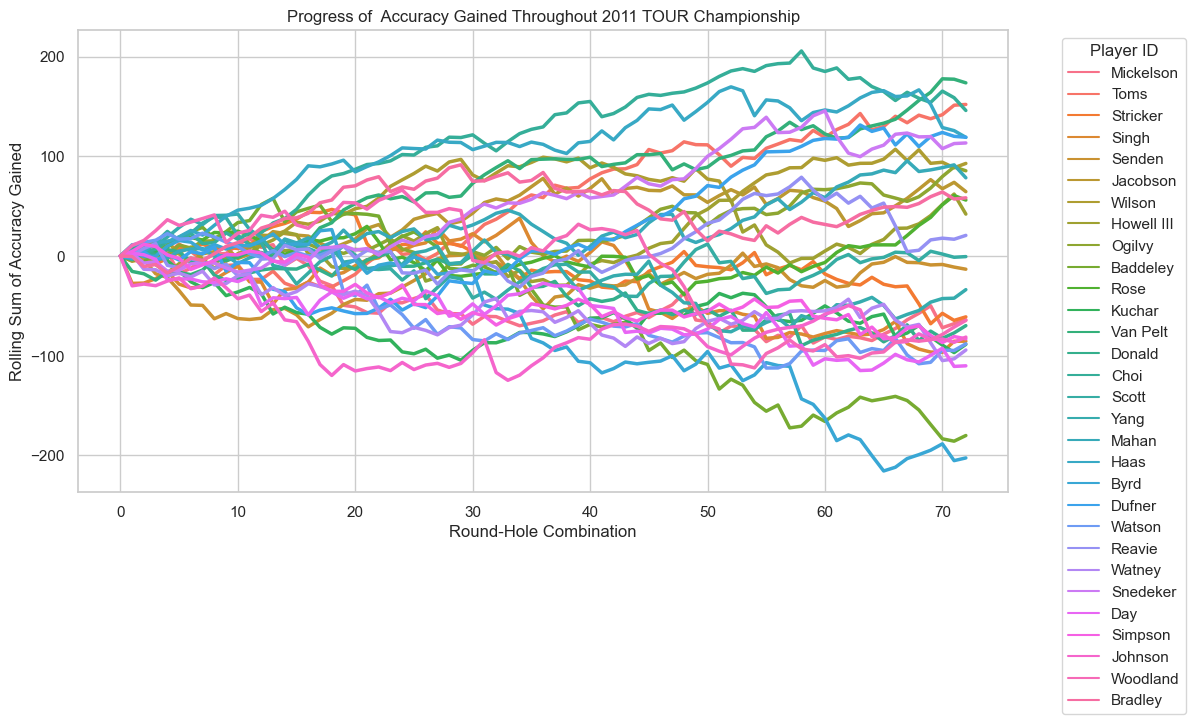

In [19]:
original_df = df[['last_name', 'round_hole_combination', 'cg_per_hole_per_round_per_player', 'rolling_sum_cg_per_hole_per_round_per_player']]

# Create a new DataFrame with additional rows
extra_rows = pd.DataFrame(columns=original_df.columns)

# Iterate through unique player_ids and add rows with specified conditions
for player_id in original_df['last_name'].unique():
    extra_row = pd.DataFrame({'last_name': [player_id], 'round_hole_combination': [0], 'cg_per_hole_per_round_per_player': [0], 'rolling_sum_cg_per_hole_per_round_per_player': [0]})
    extra_rows = pd.concat([extra_rows, extra_row], ignore_index=True)

# Concatenate the original DataFrame and the new rows
new_df = pd.concat([original_df, extra_rows], ignore_index=True)


palette = sns.color_palette("husl", n_colors=len(new_df['last_name'].unique()))

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=new_df, x='round_hole_combination', y='rolling_sum_cg_per_hole_per_round_per_player', hue='last_name', palette=palette, linewidth=2.5)

# Set labels and title
plt.xlabel('Round-Hole Combination')
plt.ylabel('Rolling Sum of Accuracy Gained')
plt.title('Progress of  Accuracy Gained Throughout 2011 TOUR Championship')

# Customize the legend to show more players
plt.legend(title='Player ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [20]:
player_list = df['last_name'].unique().tolist()
list_of_lists_cg_per_hole_per_round_per_players = []
results_list = []

for player in range(0, len(player_list)):  # Assuming holes range from 1 to 18
    list_of_lists_cg_per_hole_per_round_per_players = df[
        (df['last_name'] == player_list[player])
    ]['cg_per_hole_per_round_per_player'].values.tolist()
    
    params = stats.norm.fit(list_of_lists_cg_per_hole_per_round_per_players)
    
    result_dict = {
        'Player': player_list[player],
        'Accuracy Gained':sum(list_of_lists_cg_per_hole_per_round_per_players),
        'Mean': params[0],
        'Std': params[1]
    }

    results_list.append(result_dict)

df_results = pd.DataFrame(results_list)

df_results = df_results.sort_values(by='Mean',ascending=False)

df_results = df_results.reset_index(drop=True)

df_results['AG_Mean'] = df_results['Mean'].round(2)
df_results['AG_Accuracy Gained TOTAL'] = df_results['Accuracy Gained'].round(2)
df_results['AG_Std'] = df_results['Std'].round(2)

df_results = df_results.drop(columns=['Mean','Std','Accuracy Gained'])

In [21]:
merged_df = pd.merge(df_results, percentage_true[['last_name', 'fairway_hit']], left_on='Player', right_on='last_name', how='left')

# Drop redundant 'last_name' column (if needed)
merged_df = merged_df.drop(columns=['last_name'])

merged_df['fairway_hit'] = merged_df['fairway_hit'].round(1)

merged_df = merged_df.rename(columns={'fairway_hit': 'Fairway %'})

merged_df = pd.merge(merged_df, result[['last_name', 'sg_per_hole_per_round_per_player']], left_on='Player', right_on='last_name', how='left')
merged_df = merged_df.drop(columns=['last_name'])
merged_df = merged_df.rename(columns={'sg_per_hole_per_round_per_player': 'Total SG'})

final_merged_df = pd.merge(df_results_final, merged_df, on='Player', how='left')
final_merged_df = final_merged_df.rename(columns={'DG': 'Total DG'})
final_merged_df = final_merged_df.rename(columns={'Mean': 'dg_mean'})
final_merged_df = final_merged_df.rename(columns={'Std': 'dg_std'})

final_merged_df = final_merged_df.sort_values(by='Total SG',ascending=False)

final_merged_df['Total SG'] = final_merged_df['Total SG'].round(2)

desired_order = ['Player','Total SG', 'AG_Accuracy Gained TOTAL', 'AG_Mean','AG_Std', 'Fairway %','Total DG', 'dg_mean','dg_std']
final_merged_df = final_merged_df[desired_order]

In [22]:
fig = px.scatter_3d(driving_data, 
                    x='cg_per_hole_per_round_per_player', 
                    y='Dg_per_hole_per_round_per_player', 
                    z='sg_per_hole_per_round_per_player', 
                    color='sg_per_hole_per_round_per_player',
                    opacity=0.1)

fig.update_layout(width=800, height=800, title = 'CG vs DG vs SG')

fig.update_scenes(
    xaxis=dict(range=[-40, 40]),
)

fig.update_scenes(
    yaxis=dict(range=[-80,80]),
)

fig.update_scenes(
    zaxis=dict(range=[-3, 2]),
)

fig.show()

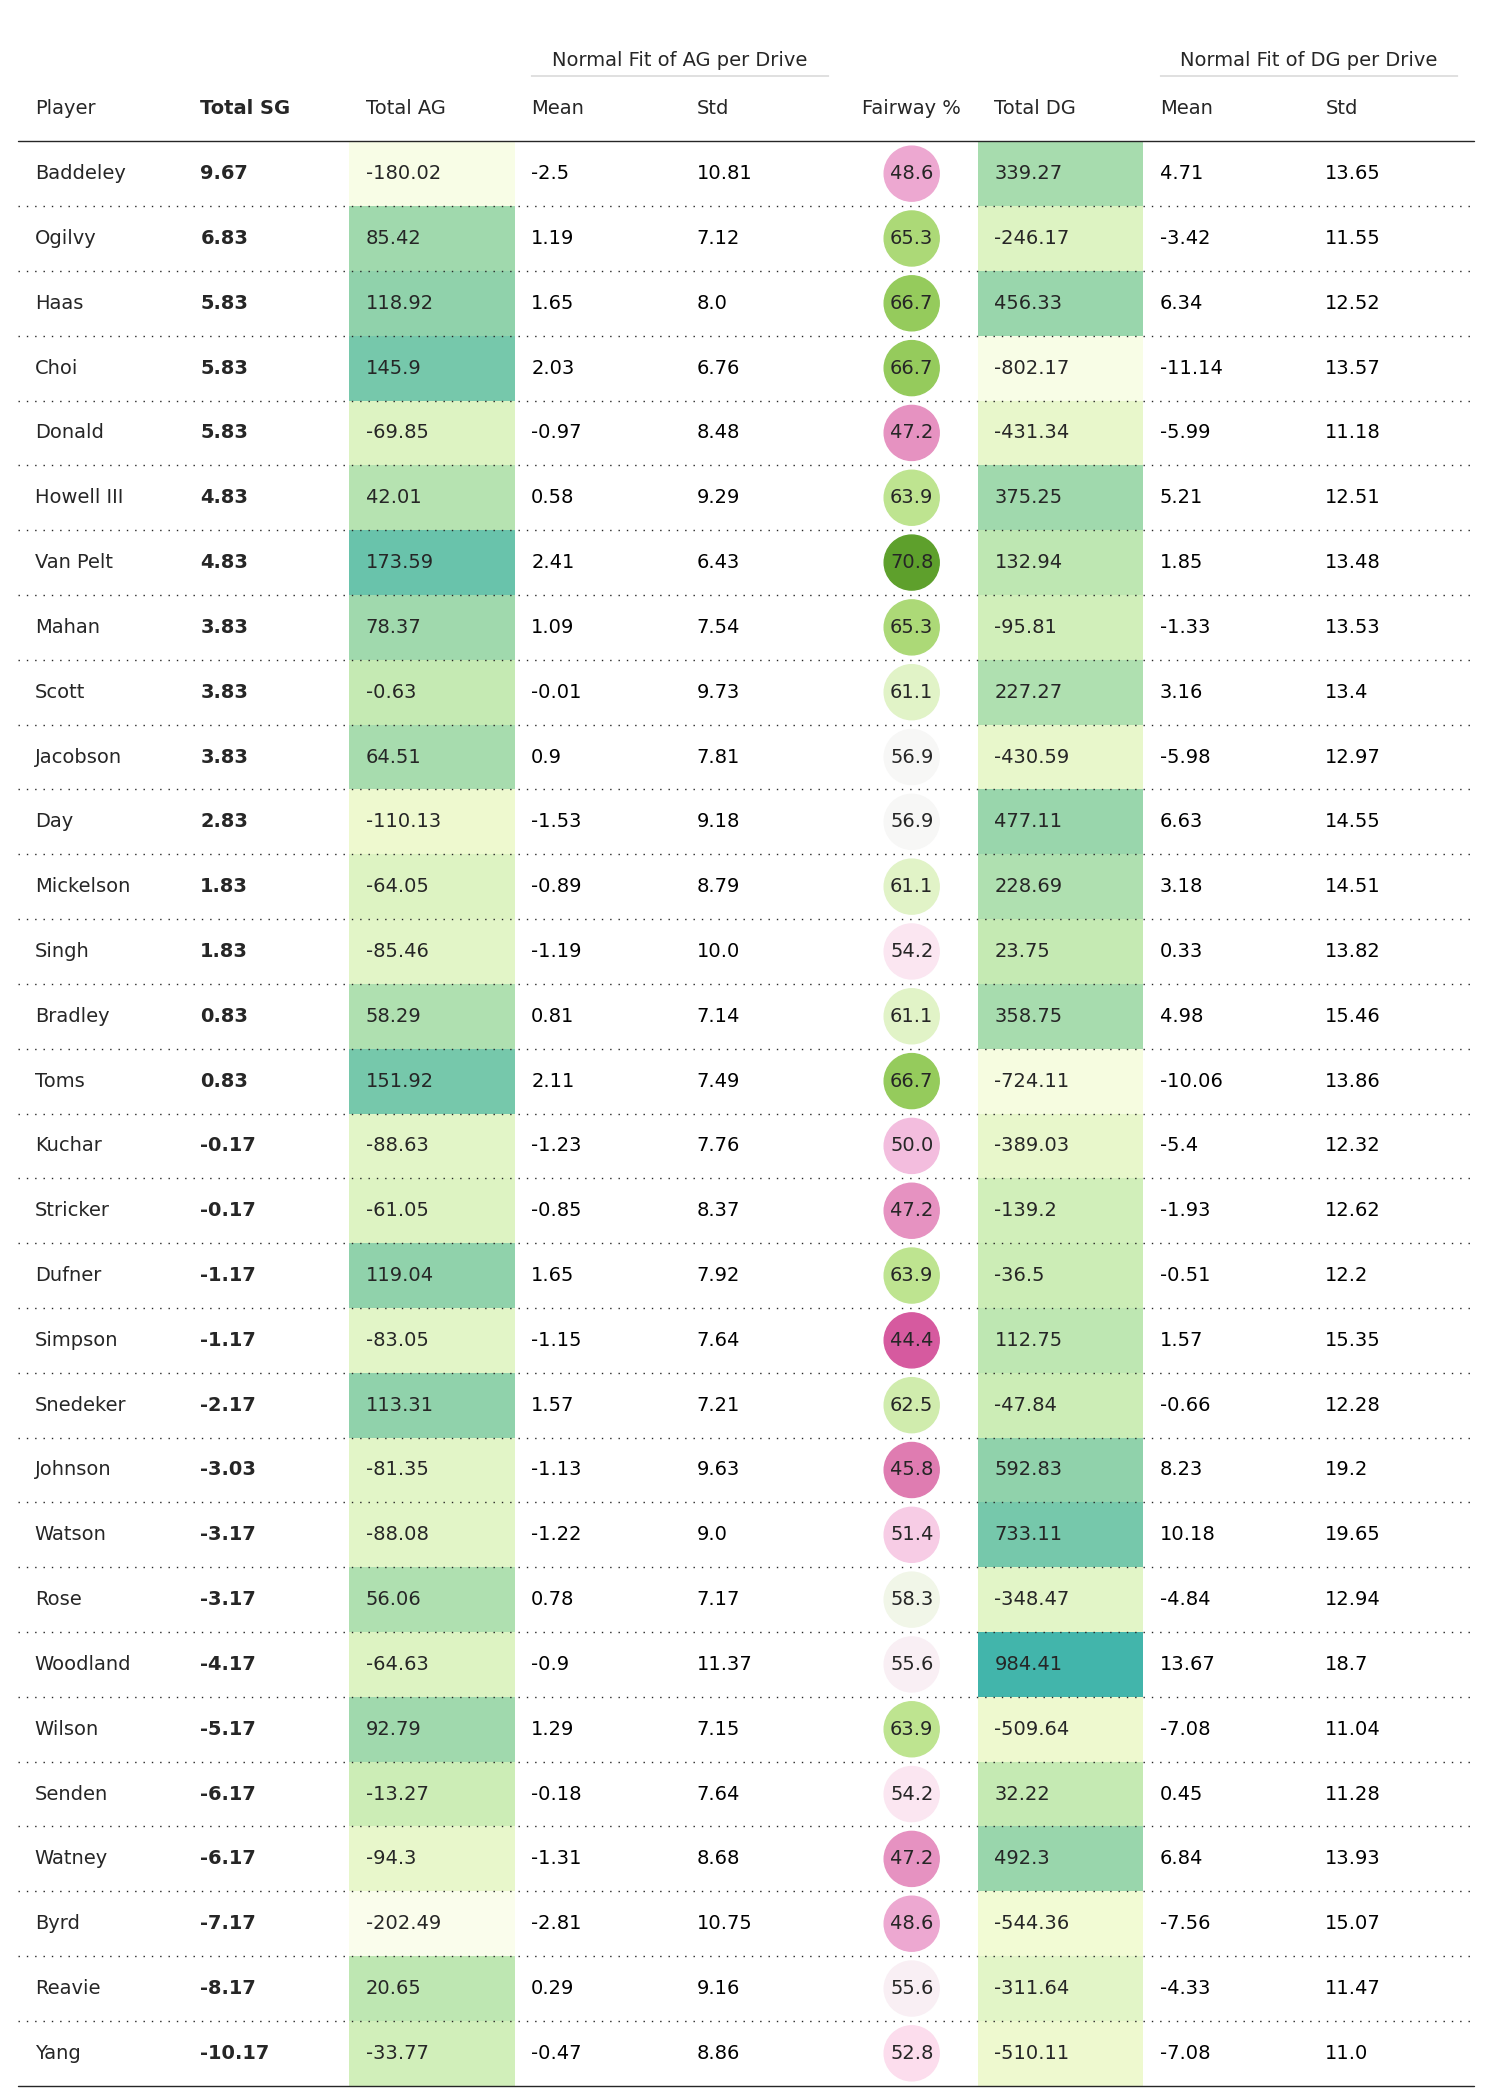

In [23]:
# do this with strokes gained, cg, pars 3s, 4s, 5s
cmap = LinearSegmentedColormap.from_list(
    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=30
)

col_defs = (
    [
        ColumnDefinition(
            name="Player",
            title="Player",
            textprops={"ha": "left"},
            width=0.5
        ),
        ColumnDefinition(
            name="Total SG",
            title="Total SG",
            textprops={"ha": "left", "weight": "bold"},
            width=0.5
        ),
        #accuracy
        ColumnDefinition(
            name="AG_Accuracy Gained TOTAL",
            title="Total AG",
            textprops={"ha": "left"},
            width=0.5,
            cmap=normed_cmap(final_merged_df["AG_Accuracy Gained TOTAL"], cmap=cmap, num_stds=2.5)
        ),
        ColumnDefinition(
            name="Fairway %",
            title="Fairway %",
            width=0.4,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle"}},
            cmap=normed_cmap(final_merged_df["Fairway %"], cmap=matplotlib.cm.PiYG, num_stds=2.5),    
        ),
        ColumnDefinition(
            name="AG_Mean",
            title="Mean",
            group="Normal Fit of AG per Drive",
            textprops={"ha": "left"},
            width=0.5
        ),
        ColumnDefinition(
            name="AG_Std",
            title="Std",
            group="Normal Fit of AG per Drive",
            textprops={"ha": "left"},
            width=0.5
        ),
        #driving distance
        ColumnDefinition(
            name="Total DG",
            title="Total DG",
            textprops={"ha": "left"},
            width=0.5,
            cmap=normed_cmap(final_merged_df["Total DG"], cmap=cmap, num_stds=2.5)
        ),
        ColumnDefinition(
            name="dg_mean",
            title="Mean",
            group="Normal Fit of DG per Drive",
            textprops={"ha": "left"},
            width=0.5
        ),
        ColumnDefinition(
            name="dg_std",
            title="Std",
            group="Normal Fit of DG per Drive",
            textprops={"ha": "left"},
            width=0.5
        )
    ])

plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

fig, ax = plt.subplots(figsize=(19, 27))

table = Table(
    final_merged_df,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    index_col="Player",
    textprops={"fontsize": 14},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
).autoset_fontcolors(colnames=["AG_Mean", "AG_Std","dg_mean","dg_std"])